## 1. Data Visualization 
### full dataset

emotion
neutral      3434
happiness    2848
surprise      184
sadness       134
anger         126
disgust       104
Name: count, dtype: int64


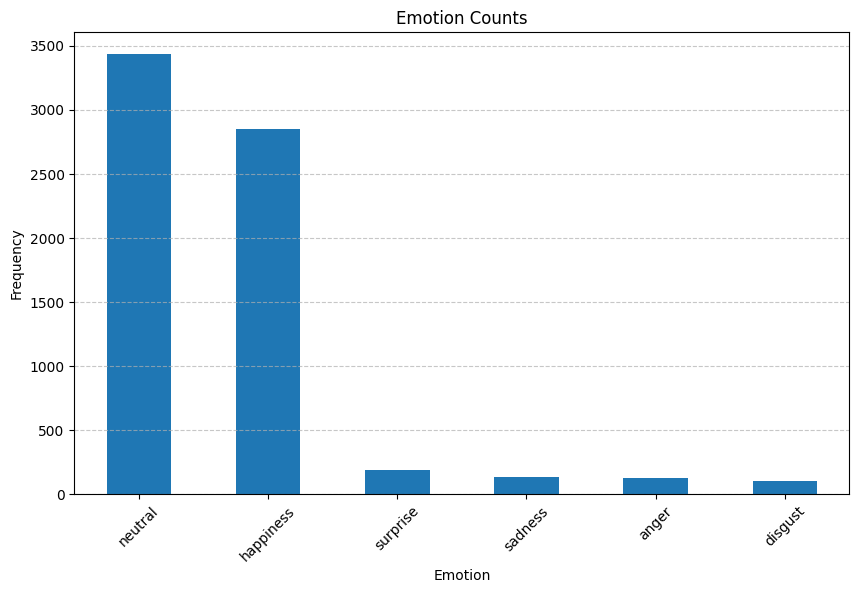

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data\\1over6_original.csv')

emotion_counts = df['emotion'].value_counts()

print(emotion_counts)

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### modified pics


emotion
neutral      3434
happiness    2848
surprise      184
sadness       134
anger         126
disgust       104
Name: count, dtype: int64


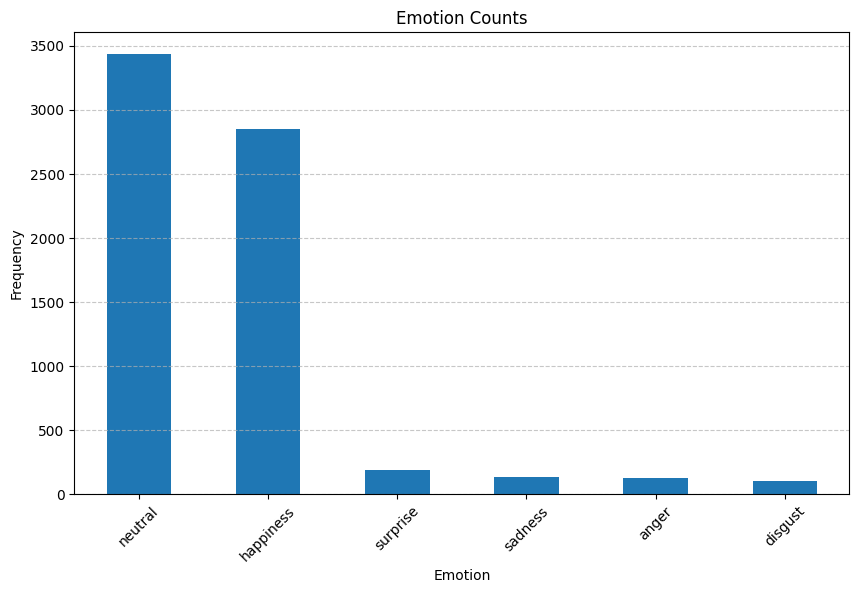

In [2]:
df = pd.read_csv('data\\1over6_original.csv')

emotion_counts = df['emotion'].value_counts()

print(emotion_counts)

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2. Train the model

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# Path
csv_file = 'data/1over6_original.csv'
image_dir = 'modified_image/'
#Read
data = pd.read_csv(csv_file, header=None, names=['user_id', 'image', 'emotion'])

# resize the dataset (I didnt find the resolution of this dataset, so i will␣↪resize them to 224x224)
image_size = (224, 224)
images = []
labels = []
for _, row in data.iterrows():
    image_path = os.path.join(image_dir, row['image'])
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size) / 255.0
        images.append(img)
        labels.append(row['emotion'])
#convert to numpy arrays
images = np.array(images)
labels = np.array(labels)



c:\Users\William\miniconda3\envs\cs178\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)


label_encoder = LabelEncoder()
y_train_svm = label_encoder.fit_transform(y_train)
y_test_svm = label_encoder.transform(y_test)

def evaluate_svm(model, X_test, y_test, label_encoder, title_prefix=""):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{title_prefix} SVM Accuracy: {accuracy:.4f}")
    emotion_labels = label_encoder.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=emotion_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({title_prefix} SVM)')
    plt.show()

    report = classification_report(y_test, y_pred, target_names=emotion_labels, output_dict=True, zero_division=0)
    print(f"{title_prefix} SVM Model Classification Report:")
    print(report)

    class_precisions = [report[label]['precision'] for label in emotion_labels if label in report]
    plt.figure(figsize=(10, 5))
    plt.bar(emotion_labels, class_precisions)
    plt.title(f'Class-wise Precision ({title_prefix} SVM)')
    plt.xlabel('Class')
    plt.ylabel('Precision')
    plt.xticks(rotation=45)
    plt.show()

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_accuracies = []

for kernel in kernels:
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train_flat, y_train_svm)
    y_pred_svm = svm_model.predict(X_test_flat)
    accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
    kernel_accuracies.append(accuracy_svm)
    print(f"SVM Accuracy (kernel={kernel}): {accuracy_svm:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(kernels, kernel_accuracies)
plt.title('SVM Kernel Comparison')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.show()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
}

grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42, class_weight='balanced'), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_flat, y_train_svm)

print("Best parameters set found on development set:")
print(grid_search.best_params_)
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

scores = np.array(means).reshape(len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'])
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Validation accuracy')
plt.show()

best_svm_model = grid_search.best_estimator_
evaluate_svm(best_svm_model, X_test_flat, y_test_svm, label_encoder, title_prefix="Best Model")

## 2. Visualize the Performance

In [ ]:

accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")
emotion_labels = data[1:]['emotion'].unique()

conf_matrix_svm = confusion_matrix(y_test_svm, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(conf_matrix_svm,display_labels=emotion_labels)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Emotion Labels (SVM)')
plt.show()


report_svm = classification_report(y_test_svm, y_pred_svm,target_names=label_encoder.classes_,output_dict=True, zero_division=0) 
print("SVM Model Classification Report:")
print(report_svm)
class_precisions_svm = [report_svm[label]['precision'] for label in label_encoder.classes_ if label in report_svm]


plt.figure(figsize=(10, 5))
plt.bar(label_encoder.classes_, class_precisions_svm)
plt.title('Class-wise Precision (SVM)')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()